**Step 3.b - Open Set classification using SVM**

This code implements a text classification pipeline using BERT to identify music captions generated by different models, incorporating an open-set recognition mechanism based on Support Vector Machines (SVM) to detect unknown classes (e.g., "SunoCaps").

It uses a Pre-trained BERT model to extract meaningful features text captions, then trains a One-class SVm on these features from known classes only. During testing, the SVM identifies unknown samples, while the BERT model handles the classification for known samples.

In [1]:
# Connection to Google Drive.
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully.")

Mounted at /content/drive
Google Drive mounted successfully.


In [2]:
# Importing all the necessary libraries.
import os
import json
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.svm import OneClassSVM # Import OneClassSVM
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tqdm.notebook import tqdm

In [3]:
# Setting seed for reproducibility.
seed_val = 42
torch.manual_seed(seed_val)
random.seed(seed_val)
np.random.seed(seed_val)
print(f"Seed set to: {seed_val}")

# GPU if it is available.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Path where the dataset with known and unknown classes is saved.
base_dataset_path = "/content/drive/MyDrive/L02CapstoneProject/FakeMusicCapsCAPTIONS2500Tot"
print(f"Base dataset path: {base_dataset_path}")

# Path where the fine-tuned BERT model was saved.
model_save_path = "/content/drive/MyDrive/L02CapstoneProject/BERT_output_model"
print(f"Fine-tuned BERT model path: {model_save_path}")

Seed set to: 42
Using device: cuda
Base dataset path: /content/drive/MyDrive/L02CapstoneProject/FakeMusicCapsCAPTIONS2500Tot
Fine-tuned BERT model path: /content/drive/MyDrive/L02CapstoneProject/BERT_output_model


In [4]:
# Data Loading and Tokenization Functions.

def load_data_from_folders(base_path, excluded_label=None):
    """
    Loads data from JSON files in subfolders, excluding a specific label if provided.
    If the base folder itself contains JSON files, it loads them with the label
    equal to the base folder's name.
    """
    data = []
    print(f"Loading data from {base_path}...")

    # Check if the base_path itself contains JSON files
    is_base_folder_data = False
    try:
        files_in_base = [f for f in os.listdir(base_path) if f.endswith(".json")]
        if files_in_base:
            print(f"   Found {len(files_in_base)} JSON files directly in {base_path}.")
            label = os.path.basename(base_path)
            if excluded_label and label == excluded_label:
                print(f"   Excluded folder (as label): {label}")
            else:
                is_base_folder_data = True
                for file in files_in_base:
                    file_path = os.path.join(base_path, file)
                    try:
                        with open(file_path, 'r') as f:
                            json_data = json.load(f)
                            caption_data = json_data.get('0', {})
                            caption = caption_data.get("text", "")
                            if caption:
                                data.append({"text": caption, "label": label})
                    except Exception as e:
                        print(f"   Error reading {file_path}: {e}")
    except Exception as e:
        print(f"   Error directly reading files in {base_path}: {e}")

    if not is_base_folder_data:
        for label_folder in os.listdir(base_path):
            if excluded_label and label_folder == excluded_label:
                print(f"   Excluded folder: {label_folder}")
                continue

            label_path = os.path.join(base_path, label_folder)
            if os.path.isdir(label_path):
                for file in os.listdir(label_path):
                    if file.endswith(".json"):
                        file_path = os.path.join(label_path, file)
                        try:
                            with open(file_path, 'r') as f:
                                json_data = json.load(f)
                                caption_data = json_data.get('0', {})
                                caption = caption_data.get("text", "")
                                if caption:
                                    data.append({"text": caption, "label": label_folder})
                        except Exception as e:
                            print(f"   Error reading {file_path}: {e}")

    print(f"Data loading complete. Total samples loaded: {len(data)}")
    return pd.DataFrame(data)

In [5]:
# Initialize BERT tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print("BERT tokenizer loaded: bert-base-uncased")

def tokenize_and_create_dataloader(sentences, labels=None, max_len=128, batch_size=16, shuffle=False):
    input_ids = []
    attention_masks = []

    for sent in sentences:
        encoded = tokenizer.encode_plus(
            sent,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)

    if labels is not None:
        labels_tensor = torch.tensor(labels)
        dataset = TensorDataset(input_ids, attention_masks, labels_tensor)
    else:
        dataset = TensorDataset(input_ids, attention_masks)

    sampler = RandomSampler(dataset) if shuffle else SequentialSampler(dataset)
    dataloader = DataLoader(dataset, sampler=sampler, batch_size=batch_size)
    return dataloader

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

BERT tokenizer loaded: bert-base-uncased


In [6]:
# Feature Extraction Function using BERT.

def get_bert_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    print("Extracting BERT embeddings...")
    for batch in tqdm(dataloader, desc="Extracting Embeddings"):
        if len(batch) == 3:
            b_input_ids, b_input_mask, _ = [t.to(device) for t in batch]
        else:
            b_input_ids, b_input_mask = [t.to(device) for t in batch]

        with torch.no_grad():
            outputs = model.bert(b_input_ids, attention_mask=b_input_mask)
            # Take the embedding of the [CLS] token (first token)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeddings)
    print("Embedding extraction complete.")
    return np.vstack(embeddings)


In [7]:
# Data Preparation for Open-Set with OCSVM.

# Load all 6 known classes for mapping.
df_known_classes_full = load_data_from_folders(base_dataset_path, excluded_label="SunoCaps10s")

# Create the original label2id and id2label mapping for the 6 known classes.
known_labels_list = sorted(df_known_classes_full["label"].unique().tolist())
label2id_known = {label: idx for idx, label in enumerate(known_labels_list)}
id2label_known = {idx: label for label, idx in label2id_known.items()}
num_known_labels = len(known_labels_list)
print(f"\nKnown classes and their mapping (ID): {label2id_known}")

# Load the "unknown" class data (SunoCaps).
df_suno_caps = load_data_from_folders(os.path.join(base_dataset_path, "SunoCaps10s"))
df_suno_caps["label_text"] = df_suno_caps["label"]

# Assign the numerical ID for the unknown class.
unknown_class_id = num_known_labels
print(f"ID assigned to the unknown class (SunoCaps10s): {unknown_class_id}")

# Create the extended mapping label2id_open_set and id2label_open_set.
open_set_labels_list = known_labels_list + ["SunoCaps10s"]
label2id_open_set = {label: idx for idx, label in enumerate(open_set_labels_list)}
id2label_open_set = {idx: label for label, idx in label2id_open_set.items()}
print(f"\nExtended mapping for open-set (ID): {label2id_open_set}")

from sklearn.model_selection import train_test_split

df_train_known, df_test_known_simulated = train_test_split(
    df_known_classes_full,
    test_size=0.5,
    stratify=df_known_classes_full["label"],
    random_state=42
)

# Apply numerical labels.
df_train_known["label_encoded"] = df_train_known["label"].map(label2id_known)

# Prepare the test set for known classes.
df_test_known_simulated["label_text"] = df_test_known_simulated["label"]
df_test_known_simulated["label_encoded"] = df_test_known_simulated["label"].map(label2id_known)


# Combine the test set of known classes with the unknown class for open-set evaluation.
df_test_open_set = pd.concat([
    df_test_known_simulated[['text', 'label_text', 'label_encoded']],
    df_suno_caps[['text', 'label_text']].assign(label_encoded=unknown_class_id)
], ignore_index=True)

# Final numerical label column for plotting.
df_test_open_set['label'] = df_test_open_set['label_text'].map(label2id_open_set)

print(f"\nTest set Open-Set created with {len(df_test_open_set)} samples.")
print("Label distribution in Open-Set Test set:")
print(df_test_open_set['label_text'].value_counts())

Loading data from /content/drive/MyDrive/L02CapstoneProject/FakeMusicCapsCAPTIONS2500Tot...
   Error reading /content/drive/MyDrive/L02CapstoneProject/FakeMusicCapsCAPTIONS2500Tot/MusicGen_medium/mWuX--EEq2E_captions.json: Expecting value: line 1 column 1 (char 0)
   Excluded folder: SunoCaps10s
Data loading complete. Total samples loaded: 15029

Known classes and their mapping (ID): {'MusicCaps': 0, 'MusicGen_medium': 1, 'audioldm2': 2, 'musicldm': 3, 'mustango': 4, 'stable_audio_open': 5}
Loading data from /content/drive/MyDrive/L02CapstoneProject/FakeMusicCapsCAPTIONS2500Tot/SunoCaps10s...
   Found 63 JSON files directly in /content/drive/MyDrive/L02CapstoneProject/FakeMusicCapsCAPTIONS2500Tot/SunoCaps10s.
Data loading complete. Total samples loaded: 63
ID assigned to the unknown class (SunoCaps10s): 6

Extended mapping for open-set (ID): {'MusicCaps': 0, 'MusicGen_medium': 1, 'audioldm2': 2, 'musicldm': 3, 'mustango': 4, 'stable_audio_open': 5, 'SunoCaps10s': 6}

Test set Open-Set 

In [8]:
# Load the BERT model.
bert_model = BertForSequenceClassification.from_pretrained(
    model_save_path,
    num_labels=num_known_labels,
    output_attentions=False,
    output_hidden_states=False,
)
bert_model.to(device)
bert_model.eval()
print(f"\nBERT model loaded from: {model_save_path}. Training classes: {num_known_labels}.")


# Create DataLoader for OCSVM training data (only known classes)
dataloader_ocsvm_train = tokenize_and_create_dataloader(
    df_train_known["text"].values,
    batch_size=16,
    shuffle=False
)
X_train_ocsvm = get_bert_embeddings(bert_model, dataloader_ocsvm_train, device)
print(f"Shape of OCSVM training embeddings: {X_train_ocsvm.shape}")

# Create DataLoader for the full Open-Set Test data (known + unknown)
dataloader_open_set_eval = tokenize_and_create_dataloader(
    df_test_open_set["text"].values,
    batch_size=16,
    shuffle=False
)
X_test_open_set_embeddings = get_bert_embeddings(bert_model, dataloader_open_set_eval, device)
print(f"Shape of Open-Set test embeddings: {X_test_open_set_embeddings.shape}")




BERT model loaded from: /content/drive/MyDrive/L02CapstoneProject/BERT_output_model. Training classes: 6.
Extracting BERT embeddings...


Extracting Embeddings:   0%|          | 0/470 [00:00<?, ?it/s]

Embedding extraction complete.
Shape of OCSVM training embeddings: (7514, 768)
Extracting BERT embeddings...


Extracting Embeddings:   0%|          | 0/474 [00:00<?, ?it/s]

Embedding extraction complete.
Shape of Open-Set test embeddings: (7578, 768)


In [18]:
# Train One-Class SVM.
print("\nTraining One-Class SVM...")
ocsvm_model = OneClassSVM(kernel='rbf', nu=0.05, gamma='auto')
ocsvm_model.fit(X_train_ocsvm)
print("One-Class SVM training complete.")


Training One-Class SVM...
One-Class SVM training complete.


In [19]:
# Open-Set Prediction using OCSVM and BERT.

print("\nPerforming Open-Set classification with OCSVM and BERT...")
true_labels_ocsvm_open_set = df_test_open_set["label"].values
predicted_labels_ocsvm_open_set = []

# Make predictions with the OCSVM
ocsvm_predictions = ocsvm_model.predict(X_test_open_set_embeddings)

# Get BERT multi-class predictions for all test samples
bert_mc_preds = []
bert_mc_probs = []
dataloader_bert_mc_prediction = tokenize_and_create_dataloader(
    df_test_open_set["text"].values,
    batch_size=16,
    shuffle=False
)

for batch in tqdm(dataloader_bert_mc_prediction, desc="BERT Multi-class Predictions"):
    if len(batch) == 3:
        b_input_ids, b_input_mask, _ = [t.to(device) for t in batch]
    else:
        b_input_ids, b_input_mask = [t.to(device) for t in batch]

    with torch.no_grad():
        outputs = bert_model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    preds = torch.argmax(logits, dim=1)

    bert_mc_preds.extend(preds.cpu().numpy())
    bert_mc_probs.extend(probs.cpu().numpy())


for i in range(len(ocsvm_predictions)):
    if ocsvm_predictions[i] == -1:
        predicted_labels_ocsvm_open_set.append(unknown_class_id)
    else:
        predicted_labels_ocsvm_open_set.append(bert_mc_preds[i])

print("Open-Set classification with OCSVM and BERT complete.")


Performing Open-Set classification with OCSVM and BERT...


BERT Multi-class Predictions:   0%|          | 0/474 [00:00<?, ?it/s]

Open-Set classification with OCSVM and BERT complete.



Label names for reports: ['MusicCaps', 'MusicGen_medium', 'audioldm2', 'musicldm', 'mustango', 'stable_audio_open', 'SunoCaps10s']

Raw Confusion Matrix (OCSVM Open-Set):
[[ 89  86  83 665 156  88  83]
 [ 82 795  83  26  60 124  80]
 [109 104  44  30  61 837  65]
 [722 108  49  27  88 161  95]
 [ 90  53  73  72 794  93  80]
 [ 53  97 829  31  68  65 117]
 [  9   6  19  11  11   7   0]]

Normalized Confusion Matrix (OCSVM Open-Set - percentages per row):
[[0.0712     0.0688     0.0664     0.532      0.1248     0.0704
  0.0664    ]
 [0.0656     0.636      0.0664     0.0208     0.048      0.0992
  0.064     ]
 [0.0872     0.0832     0.0352     0.024      0.0488     0.6696
  0.052     ]
 [0.5776     0.0864     0.0392     0.0216     0.0704     0.1288
  0.076     ]
 [0.07171315 0.04223108 0.05816733 0.05737052 0.63266932 0.07410359
  0.06374502]
 [0.04206349 0.07698413 0.65793651 0.02460317 0.05396825 0.0515873
  0.09285714]
 [0.14285714 0.0952381  0.3015873  0.17460317 0.17460317 0.1111111

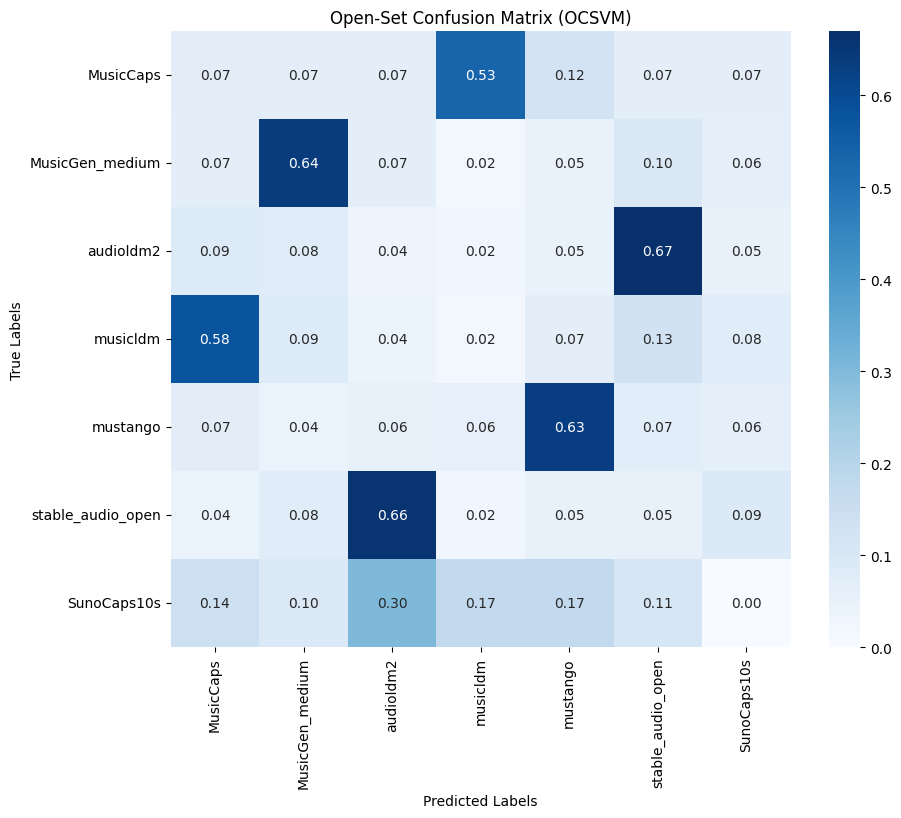


📋 Open-Set Classification Report (OCSVM):
                    precision    recall  f1-score   support

        MusicCaps       0.08      0.07      0.07      1250
  MusicGen_medium       0.64      0.64      0.64      1250
        audioldm2       0.04      0.04      0.04      1250
         musicldm       0.03      0.02      0.03      1250
         mustango       0.64      0.63      0.64      1255
stable_audio_open       0.05      0.05      0.05      1260
      SunoCaps10s       0.00      0.00      0.00        63

         accuracy                           0.24      7578
        macro avg       0.21      0.21      0.21      7578
     weighted avg       0.24      0.24      0.24      7578


--- Open-Set Evaluation with OCSVM Completed ---


In [20]:
# --- Visualization of Results ---

# Label names for Confusion Matrix and Classification Report
open_set_labels_display_names = [id2label_open_set[i] for i in sorted(id2label_open_set.keys())]
print(f"\nLabel names for reports: {open_set_labels_display_names}")

# Calculate Confusion Matrix
cm_ocsvm_open_set = confusion_matrix(
    true_labels_ocsvm_open_set,
    predicted_labels_ocsvm_open_set,
    labels=[i for i in sorted(id2label_open_set.keys())] # Ensure correct label order
)
print("\nRaw Confusion Matrix (OCSVM Open-Set):")
print(cm_ocsvm_open_set)

# Normalize Confusion Matrix
cm_ocsvm_open_set_normalized = cm_ocsvm_open_set.astype('float') / cm_ocsvm_open_set.sum(axis=1)[:, np.newaxis]
print("\nNormalized Confusion Matrix (OCSVM Open-Set - percentages per row):")
print(cm_ocsvm_open_set_normalized)

# Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_ocsvm_open_set_normalized, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=open_set_labels_display_names,
            yticklabels=open_set_labels_display_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(f'Open-Set Confusion Matrix (OCSVM)')
plt.show()

# Classification Report
print("\n📋 Open-Set Classification Report (OCSVM):\n",
      classification_report(true_labels_ocsvm_open_set, predicted_labels_ocsvm_open_set,
                            target_names=open_set_labels_display_names, zero_division=0))

print("\n--- Open-Set Evaluation with OCSVM Completed ---")